# **Variational Autoencoder with a Normalizing Flow prior** ${\P}$ 

In [1]:
import pyro
import torch
import torch.nn as nn
import torch.utils.data as data
import zuko

from pyro.contrib.zuko import ZukoToPyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from torch import Tensor
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image
from tqdm import tqdm

## Model

In [3]:
class GaussianEncoder(nn.Module):
    def __init__(self, features: int, latent: int):
        super().__init__()

        self.hyper = nn.Sequential(
            nn.Linear(features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * latent),
        )

    def forward(self, x: Tensor):
        phi = self.hyper(x)
        mu, log_sigma = phi.chunk(2, dim=-1)

        return pyro.distributions.Normal(mu, log_sigma.exp()).to_event(1)


class BernoulliDecoder(nn.Module):
    def __init__(self, features: int, latent: int):
        super().__init__()

        self.hyper = nn.Sequential(
            nn.Linear(latent, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, features),
        )

    def forward(self, z: Tensor):
        phi = self.hyper(z)
        rho = torch.sigmoid(phi)

        return pyro.distributions.Bernoulli(rho).to_event(1)

In [4]:
class VAE(nn.Module):
    def __init__(self, features: int, latent: int = 16):
        super().__init__()

        self.encoder = GaussianEncoder(features, latent)
        self.decoder = BernoulliDecoder(features, latent)

        self.prior = zuko.flows.MAF(
            features=latent,
            transforms=3,
            hidden_features=(256, 256),
        )

    def model(self, x: Tensor):
        """
        p(x|z)p(z)
        """
        pyro.module("prior", self.prior)
        pyro.module("decoder", self.decoder)

        with pyro.plate("batch", len(x)):
            z = pyro.sample("z", ZukoToPyro(self.prior()))
            x = pyro.sample("x", self.decoder(z), obs=x)

    def guide(self, x: Tensor):
        """
        q(z|x)
        """
        pyro.module("encoder", self.encoder)

        with pyro.plate("batch", len(x)):
            z = pyro.sample("z", self.encoder(x))

In [6]:
from typing import Tuple, Union, Type

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from torch import Tensor as tt
from torchvision.utils import make_grid

import pyro.infer as infer
import pyro.optim as optim
import pyro.distributions as dist

from utils import seed_everything
from rVAE.modules import InferenceNetwork, SpatialGenerator, VanillaGenerator


def grid2xy(X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
    X = torch.cat((X1[None], X2[None]), 0)
    d0, d1 = X.shape[0], X.shape[1] * X.shape[2]
    X = X.reshape(d0, d1).T
    return X


def imcoordgrid(in_dim: Union[int, Tuple]) -> torch.Tensor:
    if isinstance(in_dim, Tuple):
        xx = torch.linspace(-1, 1, in_dim[0])
        yy = torch.linspace(1, -1, in_dim[1])
    elif isinstance(in_dim, int):
        sqrt_dim = int(math.sqrt(in_dim))
        xx = torch.linspace(-1, 1, sqrt_dim)
        yy = torch.linspace(1, -1, sqrt_dim)
    else:
        return None  # Handle other cases explicitly if needed

    # Update torch.meshgrid with explicit indexing
    x0, x1 = torch.meshgrid(xx, yy, indexing="ij")
    return grid2xy(x0, x1)


def transform_coordinates(
    coord: torch.Tensor,
    phi: Union[torch.Tensor, float] = 0,
    coord_dx: Union[torch.Tensor, float] = 0,
) -> torch.Tensor:

    if torch.sum(phi) == 0:
        phi = coord.new_zeros(coord.shape[0])
    rotmat_r1 = torch.stack([torch.cos(phi), torch.sin(phi)], 1)
    rotmat_r2 = torch.stack([-torch.sin(phi), torch.cos(phi)], 1)
    rotmat = torch.stack([rotmat_r1, rotmat_r2], axis=1)
    coord = torch.bmm(coord, rotmat)

    return coord + coord_dx


class rVAE(nn.Module):
    """Variational autoencoder wtih rotational and/or translational invariance (Pyro version)"""

    def __init__(
        self,
        in_dim: int = 576,  ## 24*24
        z_dim: int = 2,
        hidden_dim: int = 128,
        num_layers: int = 2,
        coord: int = 0,
        activation: str = "tanh",
        device: torch.device = "cpu",
        *args,
        **kwargs,  ## dx_prior, theta_prior
    ):
        """rVAE model
        Args:
            in_dim (int, optional): input image dimension. Defaults to 576.
            hidden_dim (int, optional): hidden dimension. Defaults to 512.
            num_layers (int, optional): number of layers. Defaults to 1.
            translation (bool, optional): whether to use translation. Defaults to False.
            dx_prior (float, optional): translation prior. Defaults to 1.0.
            theta_prior (float, optional): rotation prior. Defaults to 1.0.
            optim (str, optional): optimizer. Defaults to "Adam". options: "Adam", "SGD"
            epoch (int, optional): number of epochs. Defaults to 100.
            init_lr (float, optional): learning rate. Defaults to 1e-3.
            activation (str, optional): activation function. Defaults to "tanh". options: "tanh", "relu"
            loss_type (str, optional): loss type. Defaults to "bce_logits". options: "mse", "bce_logits".
            device (str, optional): device. Defaults to "cpu". options: "cpu", "mps", "cuda".
        """
        super().__init__(*args, **kwargs)
        pyro.clear_param_store()
        seed = kwargs.get("seed", 42)
        seed_everything(seed)

        self.in_dim = in_dim
        self.z_dim = z_dim

        self.inf_dim = z_dim + coord  ## rotation
        self.coord = coord

        self.device = device

        self.grid = imcoordgrid(in_dim).to(self.device)

        self.encoder = InferenceNetwork(
            n=in_dim,
            latent_dim=self.inf_dim,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            act_func=activation,
        ).to(self.device)

        self.decoder = (
            SpatialGenerator(
                latent_dim=z_dim,
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                act_func=activation,
            ).to(self.device)
            if self.coord
            else VanillaGenerator(
                n=in_dim,
                latent_dim=z_dim,
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                act_func=activation,
            ).to(self.device)
        )

        self.dx_prior = torch.Tensor(kwargs.get("dx_prior", [0.1])).to(self.device)

        self.to(self.device)

    def model(  ## Generator
        self,
        x: torch.Tensor,  ## single batch
        **kwargs,
    ) -> torch.Tensor:
        """
        p(x|z)p(z) or p(x, z)
        """
        # register PyTorch module "decoder" with Pyro
        pyro.module("decoder", self.decoder)
        # KLD scale factor
        beta = kwargs.get("scale_factor", 1.0)

        with pyro.plate("data", x.size(0)):
            ## setup hyprparameters for prior p(z, \theta, \DeltaX)
            z_mu = x.new_zeros(torch.Size((x.size(0), self.inf_dim)))
            z_std = x.new_ones(torch.Size((x.size(0), self.inf_dim)))

            # sample from prior
            with pyro.poutine.scale(scale=beta):
                z = pyro.sample("latent", dist.Normal(z_mu, z_std).to_event(1))

            if self.coord > 0:
                phi, dx, z = self.split_latent(z.to(self.device))
                phi.to(self.device)
                dx.to(self.device)

                if torch.sum(dx) != 0:
                    dx = (dx * self.dx_prior).unsqueeze(1)
                # transform coordinate grid
                grid = self.grid.expand(x.shape[0], *self.grid.shape)
                x_coord_prime = transform_coordinates(grid, phi, dx)
            dec_args = (x_coord_prime, z) if self.coord else (self.coord, z)
            loc_img = self.decoder(*dec_args)  ## (batch, in_dim, 1)
            # score against actual images
            pyro.sample(  ## NOTE:
                "obs",
                # dist.Bernoulli(
                #     loc_img.view(-1, self.in_dim),
                # ).to_event(1),
                dist.Normal(
                    loc_img.view(-1, self.in_dim),
                    0.5 * torch.ones_like(loc_img.view(-1, self.in_dim)),
                ).to_event(1),
                obs=x.view(-1, self.in_dim),
            )

    def guide(  ## Inferencer
        self,
        x: torch.Tensor,
        **kwargs,
    ) -> torch.Tensor:
        """
        q(z|x)
        """
        ## register PyTorch "encoder" module
        pyro.module("encoder", self.encoder)
        ## KLD scale factor
        beta = kwargs.get("scale_factor", 1.0)
        with pyro.plate("data", len(x)):
            ## use encoder to get the parameters used to define q(z|x)
            z_mu, z_logstd = self.encoder(x.to(self.device))
            with pyro.poutine.scale(scale=beta):
                pyro.sample(
                    "latent", dist.Normal(z_mu, torch.exp(z_logstd)).to_event(1)
                )

    def split_latent(self, z: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Split latent variable into parts for rotation
        and/or translation and image content
        """
        phi, dx = torch.zeros(z.shape[0]), torch.zeros(z.shape[0], 2)
        # rotation + translation
        if self.coord == 3:
            phi = z[:, 0]  # encoded angle
            dx = z[:, 1:3]  # translation
            z = z[:, 3:]  # image content
        # translation only
        elif self.coord == 2:
            dx = z[:, :2]
            z = z[:, 2:]
        # rotation only
        elif self.coord == 1:
            dx = dx.unsqueeze(1)
            phi = z[:, 0]
            z = z[:, 1:]
        return phi.to(self.device), dx.to(self.device), z

    # def _encode(self, x_new: torch.Tensor, **kwargs: int) -> torch.Tensor:
    #     """
    #     Encodes data using a trained inference (encoder) network
    #     in a batch-by-batch fashion
    #     """

    #     def inference() -> np.ndarray:
    #         with torch.no_grad():
    #             encoded = self.encoder_net(x_i)
    #         encoded = torch.cat(encoded, -1).cpu()
    #         return encoded

    #     x_new = x_new.to(self.device)
    #     num_batches = kwargs.get("num_batches", 10)
    #     batch_size = len(x_new) // num_batches
    #     z_encoded = []
    #     for i in range(num_batches):
    #         x_i = x_new[i * batch_size : (i + 1) * batch_size]
    #         z_encoded_i = inference()
    #         z_encoded.append(z_encoded_i)
    #     x_i = x_new[(i + 1) * batch_size :]
    #     if len(x_i) > 0:
    #         z_encoded_i = inference()
    #         z_encoded.append(z_encoded_i)
    #     return torch.cat(z_encoded)

    # def encode(self, x_new: torch.Tensor, **kwargs: int) -> torch.Tensor:
    #     """
    #     Encodes data using a trained inference (encoder) network
    #     (this is baiscally a wrapper for self._encode)
    #     """
    #     if isinstance(x_new, torch.utils.data.DataLoader):
    #         x_new = train_loader.dataset.tensors[0]
    #     z = self._encode(x_new)
    #     z_loc = z[:, : self.z_dim]
    #     z_scale = z[:, self.z_dim :]
    #     return z_loc, z_scale

    def manifold2d(self, d: int, **kwargs: Union[str, int]) -> torch.Tensor:
        """
        Plots a learned latent manifold in the image space
        """

        grid_x = norm.ppf(torch.linspace(0.95, 0.05, d))
        grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
        loc_img_all = []
        for i, xi in enumerate(grid_x):
            for j, yi in enumerate(grid_y):
                z_sample = tt([xi, yi]).float().to(self.device).unsqueeze(0)
                d_args = (self.grid.unsqueeze(0), z_sample)
                loc_img = self.decoder(*d_args)
                loc_img_all.append(loc_img.detach().cpu())
        loc_img_all = torch.cat(loc_img_all)

        grid = make_grid(
            loc_img_all[:, None],
            nrow=d,
            padding=kwargs.get("padding", 2),
            pad_value=kwargs.get("pad_value", 0),
        )
        plt.figure(figsize=(8, 8))
        plt.imshow(
            grid[0],
            cmap=kwargs.get("cmap", "gnuplot"),
            origin=kwargs.get("origin", "upper"),
            extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
        )
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("$z_1$", fontsize=18)
        plt.ylabel("$z_2$", fontsize=18)
        plt.show()

In [11]:
from pyro.optim import PyroOptim, Adam
from pyro import infer
from pyro.infer import ELBO, Trace_ELBO

from torch.utils.data import Dataset, DataLoader


class SVI_Trainer:
    """Stochastic variational inference trainer for
    unsupervised variational models
    """

    def __init__(
        self,
        model: Type[nn.Module],
        optimizer: Type[PyroOptim] = None,
        loss: Type[ELBO] = None,
        seed: int = 1,
        device: str = "cpu",
    ):
        """
        Initialize the trainer's parameters
        """
        pyro.clear_param_store()
        seed_everything(seed)
        self.device = device
        if optimizer is None:
            optimizer = Adam({"lr": 1e-3})
        if loss is None:
            loss = Trace_ELBO()
        self.svi = infer.SVI(
            model=model.model,
            guide=model.guide,
            optim=optimizer,
            loss=loss,
        )
        self.loss_history = {"training_loss": [], "test_loss": []}
        self.current_epoch = 0

    def train(
        self,
        TrainLoader: Type[DataLoader],
        **kwargs: float,
    ) -> float:
        """
        training one epoch
        """
        epoch_loss_accum = 0.0
        for data in TrainLoader:
            if len(data) == 1:
                x = data[0]
                loss = self.svi.step(x.to(self.device), **kwargs)
            else:
                loss = 0.0

            epoch_loss_accum += loss

        return epoch_loss_accum / len(TrainLoader.dataset)

    def evaluate(self, TestLoader: Type[DataLoader], **kwargs: float) -> float:
        """
        Evaluates current models state on a single epoch
        """
        epoch_loss_accum = 0.0
        with torch.no_grad():
            for data in TestLoader:
                if len(data) == 1:
                    x = data[0]
                    loss = self.svi.step(x.to(self.device), **kwargs)
                else:
                    loss = 0.0

                epoch_loss_accum += loss

        return epoch_loss_accum / len(TestLoader.dataset)

    def step(
        self,
        TrainLoader: Type[DataLoader],
        TestLoader: Type[DataLoader],
        **kwargs: float,
    ) -> None:
        self.loss_history["training_loss"].append(self.train(TrainLoader, **kwargs))
        if TestLoader is not None:
            self.loss_history["test_loss"].append(self.evaluate(TestLoader, **kwargs))
        self.current_epoch += 1

    def print_statistics(self) -> None:
        """prints training and test (if any) losses for current epoch"""
        e = self.current_epoch
        if len(self.loss_history["test_loss"]) > 0:
            print(
                f"Epoch: {e} Training loss: {self.loss_history['training_loss'][-1]:.4f}, Test loss: {self.loss_history['test_loss'][-1]:.4f}"
            )
        else:
            print(
                f"Epoch: {e} Training loss: {self.loss_history['training_loss'][-1]:.4f}"
            )

## Atomic Data

In [12]:
from train import load_dynamic_transition_data
from utils import imlocal

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch

SEED = 42

## Load data
STEM_real, decoded_imgs, lattice_coord = load_dynamic_transition_data("./data")

C_cnt = 0
for i in lattice_coord.keys():
    coord_arr = lattice_coord[i]
    inner_cnt = len(coord_arr) - np.count_nonzero(coord_arr[:, -1])
    C_cnt += inner_cnt

print(f"There are {C_cnt} carbon atoms in all STEM frames")

s = imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None],
    lattice_coord,
    24,
    0,
)
imgstack, imgstack_com, imgstack_frm = s.imgstack, s.imgstack_com, s.imgstack_frames

## DataLoader
imstack_train, imstack_test = train_test_split(
    imgstack, test_size=0.15, shuffle=True, random_state=SEED
)

train_dataset, val_dataset = TensorDataset(
    torch.from_numpy(
        imstack_train.transpose(0, 3, 1, 2).reshape(len(imstack_train), -1)
    )
), TensorDataset(
    torch.from_numpy(imstack_test.transpose(0, 3, 1, 2).reshape(len(imstack_test), -1)),
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=200,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=200,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
)

There are 85033 carbon atoms in all STEM frames


In [13]:
from utils import get_device

rvae = rVAE(coord=3, device=get_device())

trainer = SVI_Trainer(model=rvae, device=get_device())
for e in range(10):
    trainer.step(train_loader, val_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 220.9126, Test loss: 261.9863
Epoch: 2 Training loss: 183.1243, Test loss: 212.8969
Epoch: 3 Training loss: 168.1918, Test loss: 207.2944
Epoch: 4 Training loss: 165.0013, Test loss: 201.0072
Epoch: 5 Training loss: 163.6299, Test loss: 210.6646
Epoch: 6 Training loss: 163.0986, Test loss: 223.1875
Epoch: 7 Training loss: 165.5488, Test loss: 181.5496
Epoch: 8 Training loss: 161.5128, Test loss: 178.9502
Epoch: 9 Training loss: 160.8856, Test loss: 183.1045
Epoch: 10 Training loss: 160.6537, Test loss: 179.8624


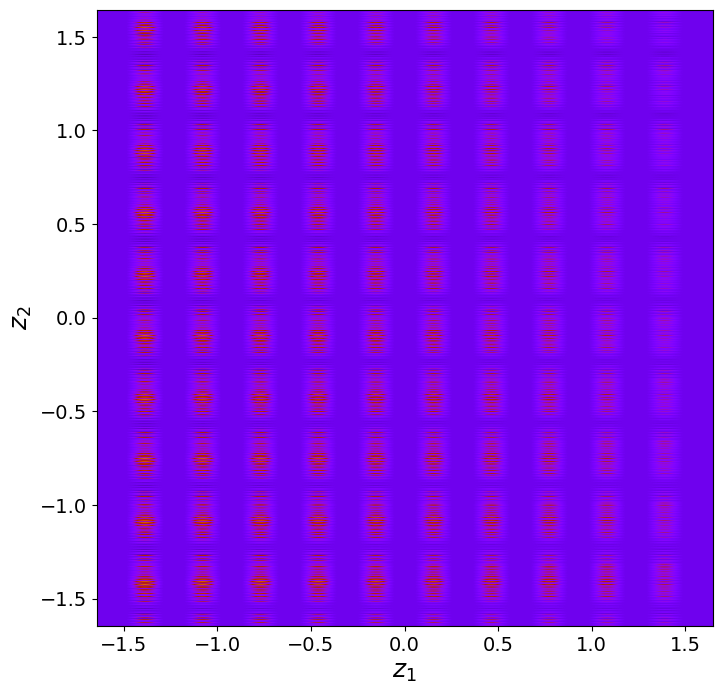

In [14]:
rvae.manifold2d(d=10)